In [0]:
#Importar librerías
import sys #Librería que provee acceso a funciones y objetos mantenidos por del intérprete
import gym #Librería para desarrollo de modelos de Aprendizaje Reforzado
import numpy as np 
import random #Generador de números aleatorios
from collections import defaultdict #módulo para  crear diccionarios]

In [0]:
juego = gym.make('Blackjack-v0') #Importación de funciones de Black Jack, info de funciones: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

# 1. Test de funcionamiento del ambiente

Estados del entorno:
*  Acumulado de valores de cartas del jugador: [0,31] i.e. 32 states
*  Carta visible de Dealer: [1,10] i.e. 10 states
*  Si tiene o no carta AS: [0,1] i.e. 2 states

Acciones:
* Seguir o parar de pedir cartas: [0,1] i.e 0 for stick , 1 for hit

In [33]:
print(juego.observation_space) #Es la estructura o tipo de datos que van a tomar las observaciones del entorno. 
print(juego.action_space) # Es la estructura o tipo de datos que va atomar la acción del agente.

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Probar el funcionamiento del proceso de decisión de Markov (MDP)

In [34]:
#Políticas de Aleatoriedad

for i_episode in range(5):
    estado = juego.reset()
    while True: #ciclo infinito a no ser que usemos un break, return.
        print(estado)
        accion = juego.action_space.sample() # Genera la acción aleatoria entre 1 (Pedir carta) y 0 (Plantarse).
        estado, premio, fin, info = juego.step(accion) # Genera el estado (Sum Jugad - Sum Dealer - As), la recompensa, Done: Significa si el juego ha terminado para el esado que se imprime.
        if fin: #Solo cuando el juego ha terminado -> done = True se establece el premio. 
            print('Juego Terminado! El premio es: ', premio)
            print('Ganaste!\n') if premio > 0 else print('Perdiste!\n')
            break

(14, 10, False)
Juego Terminado! El premio es:  -1
Perdiste!

(18, 5, False)
Juego Terminado! El premio es:  1.0
Ganaste!

(15, 4, False)
Juego Terminado! El premio es:  -1.0
Perdiste!

(20, 10, False)
Juego Terminado! El premio es:  -1
Perdiste!

(20, 3, False)
Juego Terminado! El premio es:  1.0
Ganaste!



# 2. Montecarlo Estocastico



##2.1 Política
Se define la politica de que con un 80% parar de solicitar cartas si la sumatoria de cartas es superior 18. Si es menor de 18, la política será pedir cartas con un 80% de probabilidad.

In [0]:
def ModeloPolitica80_20(bj_juego):
    episodio = []
    estado = juego.reset() #se hace reseteo del estado
    while True:
        prob = [0.8, 0.2] if estado[0] > 18 else [0.2, 0.8] #Se definen las probabilidades: si acumulado es mayor 18 probabilidad de parar es 80% y si es menor pedir con un 80% de Probabilidad
        accion = np.random.choice(np.arange(2), p=prob) #Se toma una acción con base a la probabilidad definida en la política.
        Sig_estado, premio, fin, info = juego.step(accion) #Se evalua acción de acuerdo al estado que se tenga
        episodio.append((estado, accion, premio))#Se agrega estado a lista
        estado = Sig_estado #Se asigna el nuevo estado E1 a un estado anterior, para que se corra el nuevo estado E2 (Si se cumple con las politicas) con base a la información de E1. 
        if fin:
            break
    return episodio

In [36]:
# A continuación se genera un ejemplo de la política definida, cada linea representa una jugada
for i in range(5):
    print(ModeloPolitica80_20(juego))

[((20, 10, False), 0, 0.0)]
[((16, 10, False), 1, -1)]
[((18, 8, True), 1, 0), ((16, 8, False), 1, -1)]
[((17, 6, False), 1, -1)]
[((6, 5, False), 1, 0), ((15, 5, False), 1, 0), ((18, 5, False), 1, 0), ((20, 5, False), 0, 1.0)]


Explicación de primera jugada
En el primer turno el algoritmo tenía acumulado 12 y el dealer tenía una carta 10 descubierta y no se disponía de ningún AS; con este estado del entorno el algoritmo solicita de nuevo cartas.
En el segundo turno: Tenía 18 acumulado, el dealer 10 destapado y no se disponía de ningún AS; con este estado el algoritmo decide de nuevo pedir y como resultado recibe un reward de -1

In [0]:
def ModeloMC_80_20(juego, num_episodios, generar_episodio, gamma=1.0):
    # Se inicializan los diccionarios N y Q vacíos. Con "defaultdict" cuando no exita la llave que se consulta en el diccionario, se devolvera un array de ceros con dos componentes (Mismo tamaño que juego.action_space)
    R_suma = defaultdict(lambda: np.zeros(juego.action_space.n))
    N = defaultdict(lambda: np.zeros(juego.action_space.n))
    Q = defaultdict(lambda: np.zeros(juego.action_space.n)) # Diccionario para almacenar función Q 


    # Ciclo para cada juego
    for iter_episodio in range(1, num_episodios+1):    
        # Se genera una jugada utilizando la política de 80-20:
        episodio = generar_episodio(juego)
        # Se almacenan los estados, acciones y recompensas
        estados, accion, premio = zip(*episodio)
        descuentoPrem = np.array([gamma**i for i in range(len(premio)+1)]) #descuentoPrem es un array que contendra el monto en que se ira descontando el premio con base a las decisiones del modelo.

        # Acumulación en las tablas N y Q de modo que se pueda identificar la función acción Valor.
        for i, estado in enumerate(estados): #ever-visit
            R_suma[estado][accion[i]] += sum(premio[i:]*descuentoPrem[:-(1+i)])
            N[estado][accion[i]] += 1.0
            Q[estado][accion[i]] = R_suma[estado][accion[i]] / N[estado][accion[i]] 
            #Just taking the mean of all the returns got by taking this action when we were in this state.
    return Q

In [0]:
# A continuación se simulan 500,000 jugadas y se obtiene la funcion de la las acciones tomadas en el escenario
Q = ModeloMC_80_20(juego, 500000, ModeloPolitica80_20)

La funciónQ especifica que tan bueno es para el agente realizar una acción en un determinado estado con una determinada política, para la actual (80-20) entre mayor sea el valor del estado, mejor es quedarse en ese estado de acuerdo con la política defi

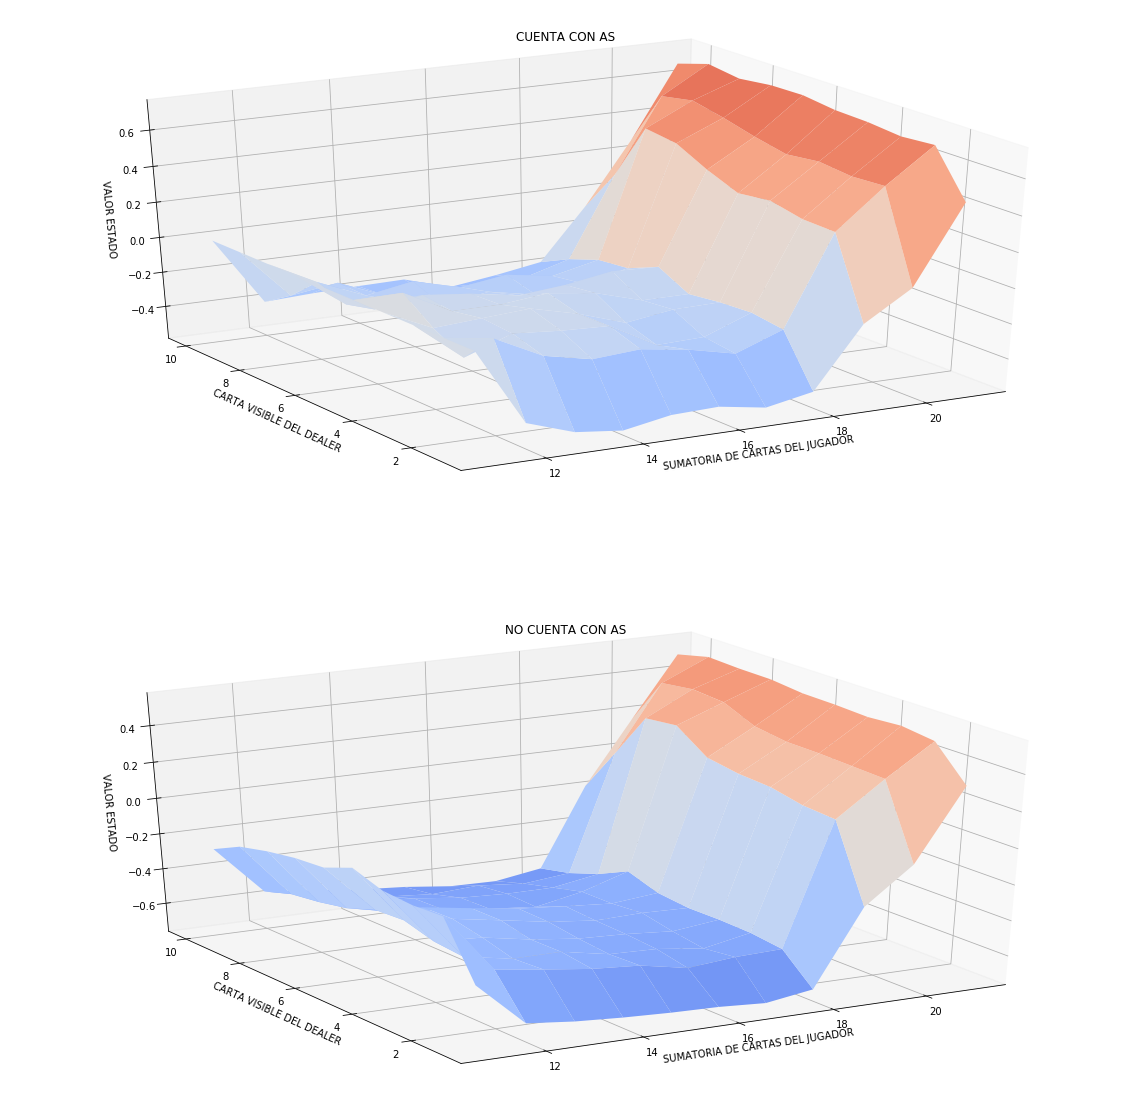

In [39]:
# A continuación se grafican los resultados de la función Q

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def Def_Z(x, y, AS):
        if (x,y,AS) in V:
            return V[x,y,AS]
        else:
            return 0

    def Plotear(AS, ax):
        x_ran = np.arange(11, 22)
        y_ran = np.arange(1, 11)
        X, Y = np.meshgrid(x_ran, y_ran)
        
        Z = np.array([Def_Z(x,y,AS) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('SUMATORIA DE CARTAS DEL JUGADOR')
        ax.set_ylabel('CARTA VISIBLE DEL DEALER')
        ax.set_zlabel('VALOR ESTADO')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('CUENTA CON AS')
    Plotear(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('NO CUENTA CON AS')
    Plotear(False, ax)
    plt.show()
    
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)    

# 3. Monte Carlo Control


## 3.1 Política
Ya no se utilizará la política estocastica definida anteriormente, ya que se reemplazará por la política de epsilon donde definiremos la porporción de explotar y explorar en el modelo.
Cuando epsilon es mas cercano al numero uno (1), tenderá a explorar en mayor proporción ante los estados simulados.

In [0]:
def Politica_prob(Estado_Q, epsilon, numeroAcciones):
    # Obtener las probabilidades de acción correspondiente a la política epsilon (Política de probabilidad de exploración --> Entre mas cercano a 1 el modelo tendera a explorar en mayor medida)
    Politica_Estado = np.ones(numeroAcciones) * epsilon / numeroAcciones
    mejor_Accion = np.argmax(Estado_Q)
    Politica_Estado[mejor_Accion] = 1 - epsilon + (epsilon / numeroAcciones)
    return Politica_Estado

### Funciones de generación de episodio y actualización de tabla Q.

In [0]:
def Gen_Episodio(juego, Q, epsilon, numeroAcciones):
    # Generación del episodio a partir de la nueva política de "epsilon".
    episodio = [] #Inicializar episodio
    estado = juego.reset() #Inicializar Estado
    while True:
        # Definición de la acción a realizar por el agente a partir de la política de epsilon.
        accion = np.random.choice(np.arange(numeroAcciones), p=Politica_prob(Q[estado], epsilon, numeroAcciones)) \
                                    if estado in Q else juego.action_space.sample()
        SiguienteEstado, premio, fin, info = juego.step(accion)
        episodio.append((estado, accion, premio)) #Acumular la información de las simulaciones en cuento al estado, la acción y el premio.
        estado = SiguienteEstado
        if fin:
            break
    return episodio

def ActualizarQ(juego, episodio, Q, alpha, gamma):
  # Actualiza la función acción/valor estimada usando el episodio más reciente.
  estados, accion, premio = zip(*episodio)
  descuentoPrem = np.array([gamma**i for i in range(len(premio)+1)])    # Array descuento premio.
  for i, estado in enumerate(estados):
    Q_Viejo = Q[estado][accion[i]]
    Q[estado][accion[i]] = Q_Viejo + alpha*(sum(premio[i:]*descuentoPrem[:-(1+i)]) - Q_Viejo)
  return Q

### Ejecución del modelo de Monte Carlo

In [0]:
def mc_control(juego, num_Episodios, alpha, gamma=1.0, epsilon_Inicial=1.0, epsilon_Reduc=.99999, epsilon_Min=0.05):
    numeroAcciones = juego.action_space.n
    #Se inicializa el diccionario Q Con "defaultdict" cuando no exita la llave que se consulta en el diccionario, se devolvera un array de ceros con la misma cantidad definida en la variable "numeroAcciones"
    Q = defaultdict(lambda: np.zeros(numeroAcciones))
    epsilon = epsilon_Inicial #Epsilon inicial con el que se iniciará ejecutando el modelo. Por lo tanto el modelo iniciara siendo de caracter exploratorio y luego ira otorgando mayor proporcionalidad a la explotacion.
    # loop over episodes
    for iter_episodios in range(1, num_Episodios+1):
        epsilon = max(epsilon*epsilon_Reduc, epsilon_Min) #Definir el valor de epsilon para la iteracion.
        episode = Gen_Episodio(juego, Q, epsilon, numeroAcciones)# Generación del episodio según el valor de epsilon.
        Q = ActualizarQ(juego, episode, Q, alpha, gamma) # Actualizar la función acción/Valor estimadad en el episodio.
    
    Politica = dict((k,np.argmax(v)) for k, v in Q.items()) # Determinar la política correspondiente a la función Acción/Valor estimada final.
    return Politica, Q

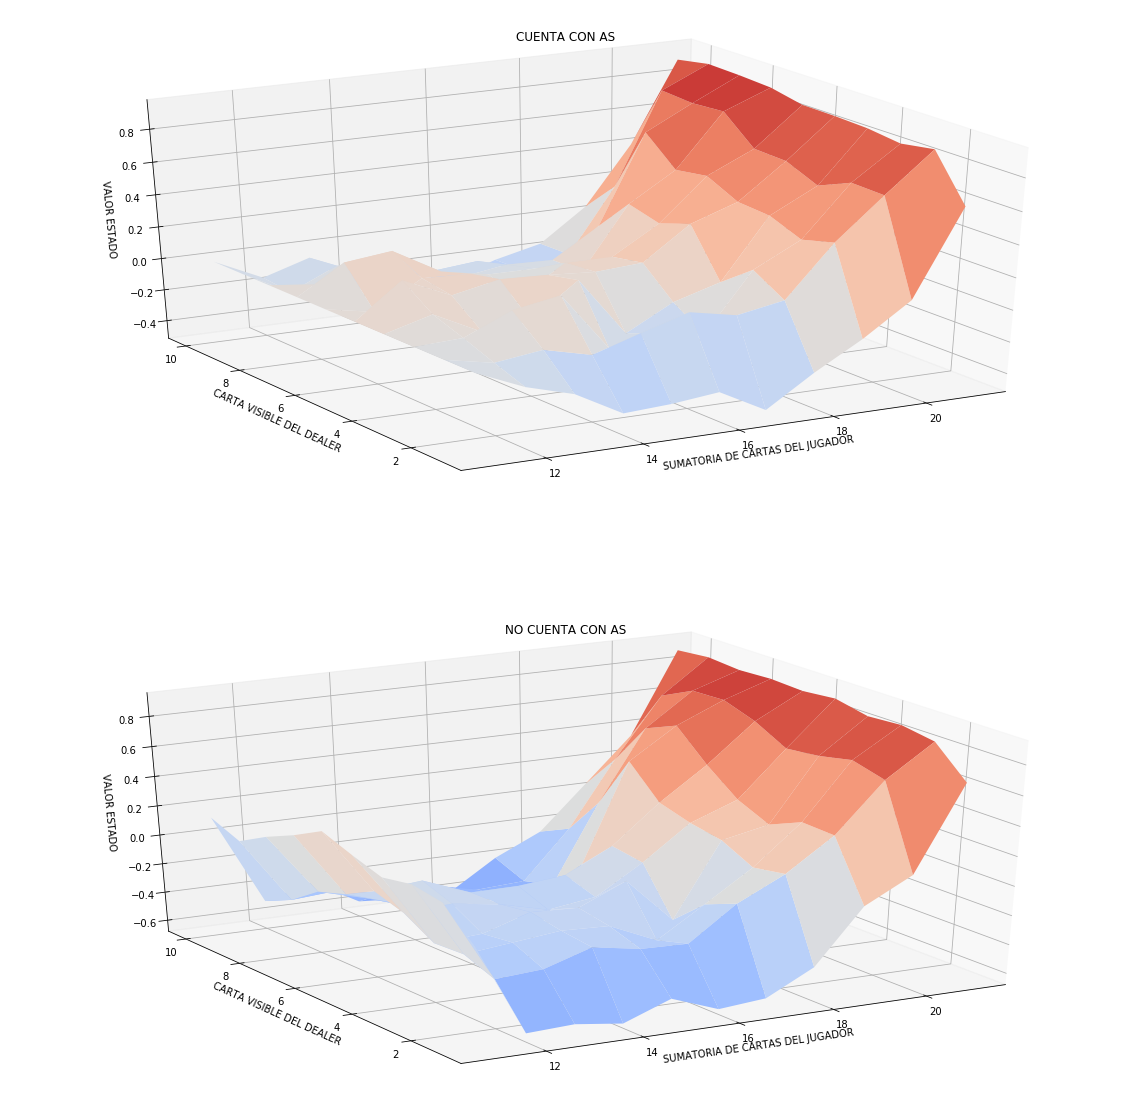

In [43]:
politica, Q = mc_control(juego, 500000, 0.015) #Estimar la politica optima y la funcion accion/Valor
V = dict((k,np.max(v)) for k, v in Q.items()) #Obtener la función Estado/Valor.
plot_blackjack_values(V)

### Políticas aprendidas por el modelos.

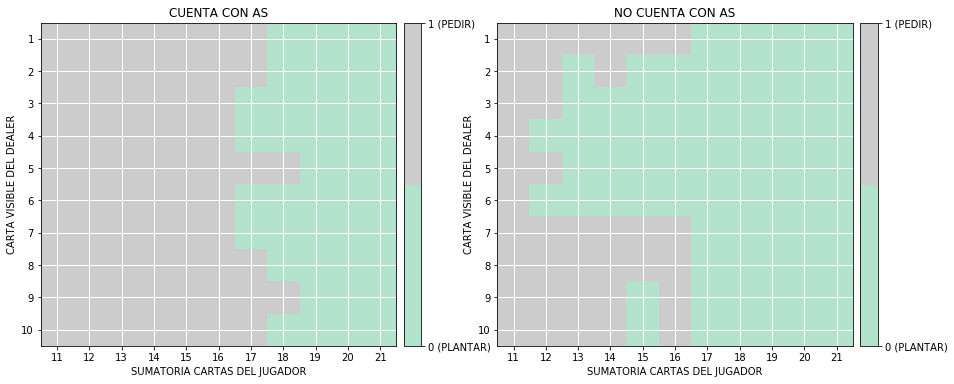

In [45]:
def Grafica_Politica(politica):

    def Def_Z(x, y, AS):
        if (x,y,AS) in politica:
            return politica[x,y,AS]
        else:
            return 1

    def get_figure(AS, ax):
        x_ran = np.arange(11, 22)
        y_ran = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_ran, y_ran)
        Z = np.array([[Def_Z(x,y,AS) for x in x_ran] for y in y_ran])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_ran)
        plt.yticks(y_ran)
        plt.gca().invert_yaxis()
        ax.set_xlabel('SUMATORIA CARTAS DEL JUGADOR')
        ax.set_ylabel('CARTA VISIBLE DEL DEALER')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (PLANTAR)','1 (PEDIR)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('CUENTA CON AS')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('NO CUENTA CON AS')
    get_figure(False, ax)
    plt.show()

# plot the policy
Grafica_Politica(politica)